In [2]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import optuna
import talib
import json
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import torch
from torch_optimizer import Ranger
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch_optimizer as optim
from IPython.display import display, clear_output
from tqdm import tqdm
import os
import sys

In [3]:
print(torch.backends.mps.is_available())

False


In [4]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config

In [5]:
config = load_yaml('../config_bTransformer.yaml')

In [6]:

'''
# 🔹 Define log file path
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)  # Ensure log directory exists
log_file_path = os.path.join(log_dir, "training_log.txt")

# 🔥 Function to Log Output to File & Console
class Logger(object):
    def __init__(self, filename=log_file_path):
        self.console = sys.__stdout__  # Keep reference to the terminal output
        self.log = open(filename, "a")  # Append mode

    def write(self, message):
        self.console.write(message)  # Print to console
        self.console.flush()
        self.log.write(message)  # Write to log file
        self.log.flush()

    def flush(self):
        self.console.flush()
        self.log.flush()

# 🔹 Redirect print statements to both console & log file
sys.stdout = Logger()
sys.stderr = sys.stdout
'''

'\n# 🔹 Define log file path\nlog_dir = "logs"\nos.makedirs(log_dir, exist_ok=True)  # Ensure log directory exists\nlog_file_path = os.path.join(log_dir, "training_log.txt")\n\n# 🔥 Function to Log Output to File & Console\nclass Logger(object):\n    def __init__(self, filename=log_file_path):\n        self.console = sys.__stdout__  # Keep reference to the terminal output\n        self.log = open(filename, "a")  # Append mode\n\n    def write(self, message):\n        self.console.write(message)  # Print to console\n        self.console.flush()\n        self.log.write(message)  # Write to log file\n        self.log.flush()\n\n    def flush(self):\n        self.console.flush()\n        self.log.flush()\n\n# 🔹 Redirect print statements to both console & log file\nsys.stdout = Logger()\nsys.stderr = sys.stdout\n'

In [7]:
all_trading_data_dfs = []
sheet_names = ['5minData11-6-2014', '5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])

In [8]:
##### Set the Date Start and End for the filtering of trading data
train_start_date = pd.to_datetime('2023-01-01')
train_end_date = pd.to_datetime('2023-05-31')
trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.drop(columns=['Symbol'], inplace=True)
trading_data_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7956 entries, 0 to 7955
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7956 non-null   datetime64[ns]
 1   Open    7956 non-null   float64       
 2   High    7956 non-null   float64       
 3   Low     7956 non-null   float64       
 4   Close   7956 non-null   float64       
 5   Volume  7956 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 373.1 KB


In [9]:
#### Setting some global variables
n_bars = config['n_past']
m_bars = config['m_future']
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']

In [10]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_volatility_momentum(df, price_col='Close', vol_window=14, mom_window=10):
    """
    Computes rolling volatility and momentum for a given price column.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical price data.
        price_col (str): Column name of the closing price.
        vol_window (int): Window size for rolling volatility calculation.
        mom_window (int): Window size for momentum calculation.

    Returns:
        pd.DataFrame: DataFrame with added 'Volatility' and 'Momentum' features.
    """

    # Ensure price column exists
    if price_col not in df.columns:
        raise ValueError(f"Column '{price_col}' not found in DataFrame")

    # 🔹 Compute Log Returns (for better volatility calculation)
    df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))

    # 🔹 Compute Rolling Volatility (Standard Deviation of Log Returns)
    df['Volatility'] = df['Log_Returns'].rolling(window=vol_window).std()

    # 🔹 Compute Momentum (Rate of Change in Price)
    df['Momentum'] = df[price_col].pct_change(periods=mom_window) * 100

    # 🔹 Drop NaN values from rolling computations
    df.dropna(inplace=True)

    return df


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    return real, imag, mag

def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   
    

In [11]:
def add_new_features_df(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']

    #data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] - (data['High'] - data['Low'])

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    data = compute_volatility_momentum(data, price_col='Close', vol_window=config['volatility_period'], mom_window=config['momentum_period'])

    data['Close_Diff'] = data['Close'].diff().fillna(0)
    data['Close_Diff_Scaled'] = data['Close_Diff']
    data['Close_Diff'] = data['Close_Diff'] * 100

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    #print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.iloc[i, data.columns.get_loc(f'fourier_real_{j+1}')] = real[j]
                data.iloc[i, data.columns.get_loc(f'fourier_imag_{j+1}')] = imag[j]
                data.iloc[i, data.columns.get_loc(f'fourier_mag_{j+1}')] = mag[j]
                #print(data.loc[i, 'Date'])
    


    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    print(f"number of na s : {data['Date'].isna().sum()}")
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    data['time_delta'] = data['Date'].diff().dt.total_seconds()
    data['time_delta'].fillna(data['time_delta'].median(), inplace=True)

    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


#### Adding additional features

In [12]:
trading_data_with_features = add_new_features_df(trading_data_raw.copy())
trading_data_with_features = trading_data_with_features.dropna()
trading_data_with_features.reset_index(drop=True, inplace=True)

number of na s : 0


C:\Users\coool\AppData\Local\Temp\ipykernel_23064\4236212493.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['time_delta'].fillna(data['time_delta'].median(), inplace=True)


In [13]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
trading_data_with_features.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7758,2023-03-19 09:24:45.034802688,2023-01-05 13:00:00,2023-02-10 12:06:15,2023-03-20 11:12:30,2023-04-25 10:18:45,2023-05-30 15:55:00,NaN
Open,7758.0,404.553225,378.915,397.45425,406.73,411.753775,422.41,8.992144
High,7758.0,404.816508,379.22,397.7025,406.95115,411.94,422.58,8.945511
Low,7758.0,404.29264,378.915,397.20125,406.51,411.52165,421.91,9.031171
Close,7758.0,404.559044,378.92,397.45125,406.743,411.75,422.4,8.990214
Volume,7758.0,786766.772622,136615.0,418575.0,597977.5,884065.25,14680996.0,778337.655097
BOLLBU,7758.0,405.772607,380.181065,398.743643,407.685584,412.704737,422.335445,8.835232
BOLLBM,7758.0,404.509381,379.6099,397.417109,406.746798,411.712063,421.132395,8.982962
BOLLBL,7758.0,403.246155,377.780783,396.0795,405.546326,410.751789,420.184965,9.209924
DONUP,7758.0,405.809818,380.45,398.7,407.695,412.78,422.58,8.802965


In [14]:
def transform_features(df):
    close_diff_features = config['Close_Diff_Features'].split(',')
    df[close_diff_features] = df[close_diff_features].sub(df['Close'], axis=0)
    return df


In [15]:
trading_data_transformed = transform_features(trading_data_with_features.copy())

In [16]:
training_features = config['training_features2'].split(',')

In [17]:
fourier_cols = get_fourier_columns()
training_features = training_features + fourier_cols

In [18]:
def get_target_scaler(df, n, target_col='Close'):
    df = df.copy()
    modified_close = []

    for i in range(0, len(df) , n):
        segment = df.iloc[i : i+n].copy()

        if len(segment) == 0:
            continue
        first_value = segment[target_col].iloc[0]
        segment[target_col] = segment[target_col] - first_value
        modified_close.extend(segment[target_col].values)

    modified_close = np.array(modified_close).reshape(-1, 1)

    target_scaler = RobustScaler()
    scaled_close = target_scaler.fit_transform(modified_close)

    return target_scaler

In [19]:
rscaler = RobustScaler()
trading_data_robust_scaled = trading_data_transformed.copy()
trading_data_robust_scaled[training_features] = rscaler.fit_transform(trading_data_transformed[training_features])

In [36]:
#time_scaler = MinMaxScaler(feature_range=(0.1, 1))
trading_data_time_scaled = trading_data_robust_scaled.copy()
trading_data_time_scaled['time_delta'] = np.log1p(trading_data_time_scaled['time_delta'])

In [37]:
trading_data_time_scaled.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7758,2023-03-19 09:24:45.034802688,2023-01-05 13:00:00,2023-02-10 12:06:15,2023-03-20 11:12:30,2023-04-25 10:18:45,2023-05-30 15:55:00,NaN
Open,7758.0,-0.005819,-3.59,-0.19,-0.01,0.175,2.67,0.355902
High,7758.0,0.257464,0.0,0.09,0.18765,0.34,2.6799,0.253886
Low,7758.0,-0.266404,-3.88,-0.35,-0.2,-0.100825,0.0,0.24845
Close,7758.0,404.559044,378.92,397.45125,406.743,411.75,422.4,8.990214
Volume,7758.0,786766.772622,136615.0,418575.0,597977.5,884065.25,14680996.0,778337.655097
BOLLBU,7758.0,0.334205,-2.478986,-0.354793,0.0,0.645207,7.551918,1.081959
BOLLBM,7758.0,0.060812,-4.966575,-0.446131,0.0,0.553869,5.608254,0.987422
BOLLBL,7758.0,-0.270137,-7.811012,-0.596848,0.0,0.403152,2.700325,1.076646
DONUP,7758.0,0.311315,-0.614087,-0.356318,0.0,0.643682,7.0657,0.954688


#### Custom Dataset for Multistep Transformer

In [45]:
from json import decoder


class FinancialDataset(Dataset):
    def __init__(self, df, features, target_col, sequence_length, forecast_horizon):
        self.df = df
        self.features = features
        self.target_col = target_col
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.df) - self.sequence_length - self.forecast_horizon

    def __getitem__(self, idx):
        # Select a rolling window of past `sequence_length` time steps
        full_seq = self.df.iloc[idx:idx + self.sequence_length + self.forecast_horizon].copy()

        ## Split into input and target
        past_seq = full_seq.iloc[:self.sequence_length]
        future_prices = full_seq.iloc[self.sequence_length:][self.target_col].values
        future_time_deltas = self.df.iloc[idx + self.sequence_length:idx + self.sequence_length + self.forecast_horizon]['time_delta'].values
        prev_closes = self.df.iloc[idx + self.sequence_length - self.forecast_horizon : idx + self.sequence_length][self.target_col].values
        # Convert to tensor (input)
        X = torch.tensor(past_seq[self.features].values, dtype=torch.float32)
        y = torch.tensor(future_prices, dtype=torch.float32)  # Multi-step output
        time_deltas = torch.tensor(future_time_deltas, dtype=torch.float32).unsqueeze(-1)
        prev_closes = torch.tensor(prev_closes, dtype=torch.float32).unsqueeze(-1)

        #combine previous closes and time deltas to form full decoder input
        decoder_input = torch.cat([prev_closes, time_deltas], dim=-1)
        return X, y, decoder_input

In [47]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: , : x.size(1), :]
        return self.dropout(x)

In [49]:
class VariationalTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, ffn_hidden_dim=256, dropout=0.1, forecast_horizon=5):
        super(VariationalTransformer, self).__init__()

        self.forecast_horizon = forecast_horizon
        self.encoder_embedding = nn.Linear(input_dim, d_model)
        self.decoder_embedding = nn.Linear(forecast_horizon * 2, d_model)  # One Close value per step
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=ffn_hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        decoder_layers = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=ffn_hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, forecast_horizon)  # Predict one value at a time
        #Learn positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len=500,  dropout=dropout)

    def forward(self, encoder_input, decoder_input):
        batch_size = encoder_input.shape[0]

        # Encode historical data
        encoder_input = self.encoder_embedding(encoder_input)
        encoder_input = self.positional_encoding(encoder_input)
        encoder_output = self.transformer_encoder(encoder_input)

        #flatten decoder input (m close bars + m time deltas)
        decoder_input = decoder_input.view(batch_size, -1)

        # Apply Decoder embedding
        decoder_hidden = self.decoder_embedding(decoder_input)
        decoder_hidden = self.positional_encoding(decoder_hidden.unsqueeze(1))
        decoder_hidden = self.transformer_decoder(decoder_hidden, encoder_output)
        
        # Output layer
        close_diffs = self.fc_out(decoder_hidden).squeeze(1)

        return close_diffs

In [42]:
# 🔹 Huber Loss for Noisy Data
def huber_loss(y_pred, y_true, delta=3.0):
    return torch.nn.functional.smooth_l1_loss(y_pred, y_true, beta=delta)


In [43]:
num_epochs = 20
d_model = 256
num_layers=4
dropout=0.05
nhead=8
learning_rate=0.001
weight_decay=1e-4
ffn_hidden_dim = 512

In [44]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [50]:
input_dim = len(training_features)
model = VariationalTransformer(input_dim=input_dim, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout, forecast_horizon=m_bars).to(device)
optimizer = optim.Ranger(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [51]:
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [52]:
def save_checkpoint(epoch, model, optimizer, loss):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved checkpoint : {checkpoint_path}")

In [53]:
def load_checkpoint(epoch, model, optimizer=None):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"❌ Checkpoint for epoch {epoch} not found!")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Loaded checkpoint from {checkpoint_path} (epoch {epoch})")
    return epoch, model, optimizer, loss

In [54]:
training_features

['BOLLBU',
 'BOLLBM',
 'BOLLBL',
 'DONUP',
 'DONMID',
 'DONLOW',
 'MA20',
 'MA50',
 'MA100',
 'EMA20',
 'PVPTR1',
 'PVPTR2',
 'PVPTR3',
 'PVPTS1',
 'PVPTS2',
 'PVPTS3',
 'Sine_TimeOfDay',
 'Cosine_TimeOfDay',
 'ADWMMA',
 'TCHR',
 'VOLMA',
 'ADJATR',
 'Volatility',
 'Momentum',
 'Close_Diff_Scaled',
 'fourier_real_2',
 'fourier_real_3',
 'fourier_real_4',
 'fourier_real_5',
 'fourier_real_6',
 'fourier_real_7',
 'fourier_real_8',
 'fourier_real_9',
 'fourier_real_10',
 'fourier_imag_2',
 'fourier_imag_3',
 'fourier_imag_4',
 'fourier_imag_5',
 'fourier_imag_6',
 'fourier_imag_7',
 'fourier_imag_8',
 'fourier_imag_9',
 'fourier_imag_10',
 'fourier_mag_2',
 'fourier_mag_3',
 'fourier_mag_4',
 'fourier_mag_5',
 'fourier_mag_6',
 'fourier_mag_7',
 'fourier_mag_8',
 'fourier_mag_9',
 'fourier_mag_10']

In [46]:
temp_training_features = training_features.copy()
#temp_training_features.remove('Close_Scaled')
trading_data_robust_scaled[temp_training_features].describe().T

,count,mean,std,min,25%,50%,75%,max
BOLLBU,7758.0,0.334205,1.081959,-2.478986,-0.354793,0.000000e+00,0.645207,7.551918
BOLLBM,7758.0,0.060812,0.987422,-4.966575,-0.446131,0.000000e+00,0.553869,5.608254
BOLLBL,7758.0,-0.270137,1.076646,-7.811012,-0.596848,0.000000e+00,0.403152,2.700325
DONUP,7758.0,0.311315,0.954688,-0.614087,-0.356318,0.000000e+00,0.643682,7.065700
DONMID,7758.0,0.057136,0.877661,-4.899510,-0.451831,0.000000e+00,0.548169,4.548062
DONLOW,7758.0,-0.232620,0.956685,-8.562165,-0.577376,0.000000e+00,0.422624,0.845709
MA20,7758.0,0.060812,0.987422,-4.966575,-0.446131,0.000000e+00,0.553869,5.608254
MA50,7758.0,0.043298,0.872667,-3.892731,-0.464205,0.000000e+00,0.535795,3.462178
MA100,7758.0,0.010186,0.809469,-2.914449,-0.500892,0.000000e+00,0.499108,2.942131
EMA20,7758.0,0.056902,0.972588,-4.862285,-0.446424,0.000000e+00,0.553576,5.503911


In [56]:
# 🔥 Create Dataset & DataLoader
dataset = FinancialDataset(trading_data_time_scaled,training_features, "Close_Diff", n_bars, m_bars)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [55]:
start_epoch = 0

#### Training Loop

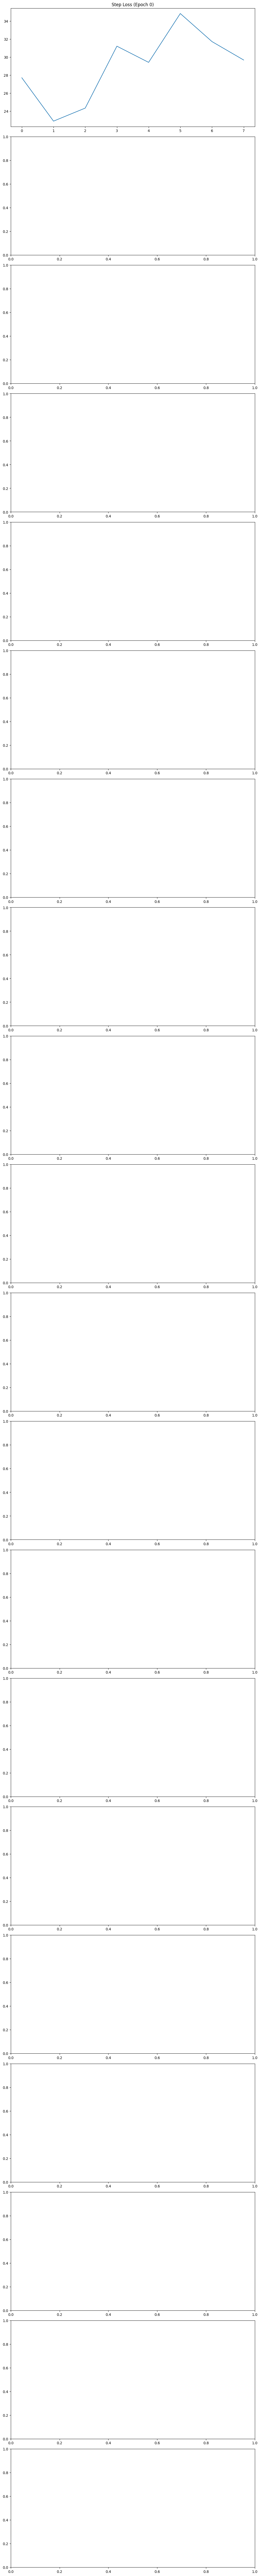

KeyboardInterrupt: 

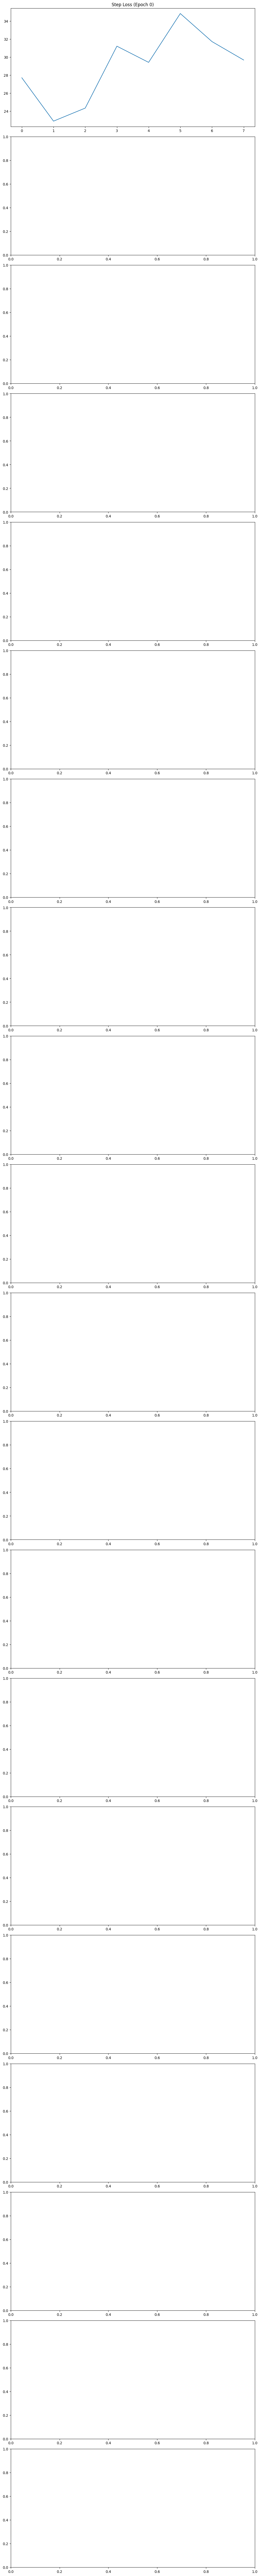

In [57]:
plt.ion()
fig, axes = plt.subplots(num_epochs,1, figsize=(10, 5 * num_epochs), constrained_layout=True)


for epoch in range(start_epoch,num_epochs):
    epoch_loss = 0.0
    loss_values = []
    ax = axes[epoch]
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch", leave=True, position=0)
    
    for step, (X_batch, y_batch, decoder_input) in enumerate(dataloader):
        #print(f"Y Batch shape : {y_batch.shape}")
        optimizer.zero_grad()
        X_batch, decoder_input, y_batch = X_batch.to(device), decoder_input.to(device), y_batch.to(device)
        y_pred = model(X_batch, decoder_input)
        y_pred = y_pred.squeeze(-1)
        print(f"y pred shape : {y_pred.shape} and y batch shape : {y_batch.shape}")
        loss = huber_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        loss_values.append(loss.item())

        progress_bar.set_postfix({'Step Loss': f'{loss.item():.6f}'})
        ax.clear()
        ax.plot(loss_values, label='Loss')
        ax.set_title(f"Step Loss (Epoch {epoch})")
        
        #plt.draw()
        #plt.pause(0.01)

        #ax.legend()
        clear_output(wait=True)
        display(fig)

    num_batches = len(dataloader)
    avg_epoch_loss = sum(loss_values) / num_batches

    progress_bar.set_postfix({'Epoch Loss': f'{avg_epoch_loss:.6f}'})
    tqdm.write(f"Epoch {epoch}/{num_epochs}, Loss: {avg_epoch_loss:.6f}")
    save_checkpoint(epoch, model, optimizer, avg_epoch_loss)

print("Training Complete !")
plt.ioff()

In [34]:
bolband_period = config['bolband_period']
donchn_period = config['donchn_period']
max_MA_period = 100
max_EMA_period = 20
tchr_period = config['tchr_period']
adwm_period = config['adwm_period']
atr_period = config['atr_period']
volume_ma_period = config['volume_ma_period']
volatility_period = config['volatility_period']
momentum_period = config['momentum_period']
fourier_lookback_window = config['fourier_lookback_window']
print(f" Fourier window : {fourier_lookback_window}")
max_window = max(bolband_period, 
                 donchn_period, 
                 max_MA_period, 
                 max_EMA_period,
                 tchr_period,
                 adwm_period,
                 atr_period,
                 volume_ma_period, fourier_lookback_window)
print(f"Max window : {max_window}")

In [ ]:
def predict_future(df, model, sequence_length, feature_scaler, t_scaler):
    model.eval()
    df_features = add_new_features_df(df.copy())
    df_features = df_features.dropna()
    df_features = df_features.iloc[-sequence_length:].copy()
    df_features.reset_index(drop=True, inplace=True)
    df_transformed = transform_features(df_features.copy())
    df_transformed['Close_Orig'] = df_transformed['Close']
    df_transformed['Close'] = df_transformed['Close'] - df_transformed['Close'].iloc[0]
    print(f"1st original Close : {df_transformed['Close_Orig'].iloc[0]}")
    print(f"Transformed close : ")
    print(df_transformed['Close'])
    training_features = config['training_features'].split(',')
    fourier_cols = get_fourier_columns()
    training_features_for_scaling = training_features + fourier_cols
    training_features = training_features + fourier_cols + ['Close_Scaled']
    trading_data_robust_scaled = df_transformed.copy()
    trading_data_robust_scaled[training_features_for_scaling] = feature_scaler.transform(trading_data_robust_scaled[training_features_for_scaling])
    trading_data_robust_scaled['Close_Scaled'] = t_scaler.transform(trading_data_robust_scaled['Close'].values.reshape(-1, 1))
    
    X_input = torch.tensor(trading_data_robust_scaled[training_features].values, dtype=torch.float32).unsqueeze(0).to(device)
    first_close = trading_data_robust_scaled['Close_Orig'].iloc[0]
    print("First close : ", first_close)
    decoder_input = torch.tensor([[trading_data_robust_scaled['Close'].iloc[-1]]], dtype=torch.float32).reshape(1,1,1).to(device)
    
    with torch.no_grad():
        y_pred = model(X_input, decoder_input).cpu().numpy().flatten()
    print(f"Y pred raw : {y_pred}")
    # Reverse normalize
    y_pred = y_pred + first_close

    return y_pred

In [56]:
def predict_data_from_point(model, start_predict_date_str, plot_graph=True, feature_scaler=None, t_scaler=None):
    #print("Hello")
    pred_start_time = pd.to_datetime(start_predict_date_str)
    pred_start_idx = all_trading_data.index[all_trading_data['Date'] >= pred_start_time][0]
    pred_before_extend = config['pred_before_extend']
    pred_after_extend = config['pred_after_extend']
    n_bars = config['n_past']
    m_bars = config['m_future']
    start_idx = max(0, pred_start_idx - n_bars - max_window - pred_before_extend)
    end_idx= min(len(all_trading_data), pred_start_idx + m_bars + pred_after_extend)
    trading_data_inference = all_trading_data.loc[start_idx:end_idx].copy()
    trading_data_inference.drop(columns=['Symbol'], inplace=True)
    # Take the first m_bars rows of trading_data_inference
    print(f"Clipping : {pred_start_idx} - {n_bars} - {max_window} = {pred_start_idx - n_bars - max_window}")
    inference_data = all_trading_data.loc[pred_start_idx - n_bars - m_bars - max_window: pred_start_idx].copy()
    
    predicted_stock_price = predict_future(inference_data, model, n_bars, feature_scaler, t_scaler)
    #print("Hello")
    print(predicted_stock_price)
    
    last_index = inference_data.index[-1]

    print(f"Last index : {last_index}")
    actual_data = trading_data_inference
    print('actual data shape : ', actual_data.shape)
    #actual_next_predicted = trading_data_inference.iloc[last_index + 1: last_index + 1 + predicted_stock_price.shape[0]]
    actual_next_predicted = trading_data_inference.loc[(last_index + 1): (last_index + 1 + predicted_stock_price.shape[0])]
    print(f"{last_index + 1} : {last_index + 1 + predicted_stock_price.shape[0]}")
    if plot_graph:
        fig = go.Figure()

        fig.add_trace(go.Candlestick(
            x=actual_data["Date"],
            open=actual_data["Open"],
            high=actual_data["High"],
            low=actual_data["Low"],
            close=actual_data["Close"],
            name="Actual Price"
        ))

        # Overlay the Predicted Close Prices as a Red Line
        fig.add_trace(go.Scatter(
            x=actual_next_predicted["Date"],
            y=predicted_stock_price,
            mode='lines+markers',
            name="Predicted Close",
            line=dict(color='blue', width=2)  # Red line for predictions
        ))

        # Layout Settings
        fig.update_layout(
            title="Stock Price Prediction vs Actual Data",
            xaxis_title="Date",
            yaxis_title="Price",
            xaxis_rangeslider_visible=False,
            yaxis=dict(fixedrange=False), 
            xaxis=dict(type='category')
        )

        # Show the chart
        fig.show()

    return predicted_stock_price

In [57]:
epoch_number, model, optimizer, loss = load_checkpoint(19, model, optimizer) 
print(loss)

In [58]:
predict_data_from_point(model,'2023-06-01 09:40:00', plot_graph=True, feature_scaler=rscaler, t_scaler=target_scaler)   

array([415.40177427, 415.40118681, 415.40118681, 415.40118681,
       415.40118681, 415.40118681, 415.40118681, 415.40118681,
       415.40118681, 415.40118681, 415.40118681, 415.40118681])

In [147]:
sys.stdout = sys.__stdout__  # Reset to console output
sys.stdout.flush()  # Flush the console output

In [1]:
print("Hello")

Hello
